In [1]:
import collections
import os
import sys
import time

import cv2
import numpy as np
from IPython import display
from openvino.runtime import Core

sys.path.append("../utils")
import notebook_utils as utils

In [2]:
# A directory where the model will be downloaded.
base_model_dir = "model"

# The name of the model from Open Model Zoo
model_name = "ssdlite_mobilenet_v2"

download_command = f"omz_downloader " \
                   f"--name {model_name} " \
                   f"--output_dir {base_model_dir} " \
                   f"--cache_dir {base_model_dir}"
! $download_command

################|| Downloading ssdlite_mobilenet_v2 ||################

========== Downloading model\public\ssdlite_mobilenet_v2\ssdlite_mobilenet_v2_coco_2018_05_09.tar.gz
... 2%, 1024 KB, 1311 KB/s, 0 seconds passed
... 4%, 2048 KB, 1794 KB/s, 1 seconds passed
... 6%, 3072 KB, 2160 KB/s, 1 seconds passed
... 8%, 4096 KB, 2382 KB/s, 1 seconds passed
... 10%, 5120 KB, 2643 KB/s, 1 seconds passed
... 12%, 6144 KB, 2809 KB/s, 2 seconds passed
... 14%, 7168 KB, 2979 KB/s, 2 seconds passed
... 16%, 8192 KB, 3101 KB/s, 2 seconds passed
... 18%, 9216 KB, 3223 KB/s, 2 seconds passed
... 20%, 10240 KB, 3326 KB/s, 3 seconds passed
... 22%, 11264 KB, 3416 KB/s, 3 seconds passed
... 24%, 12288 KB, 3480 KB/s, 3 seconds passed
... 26%, 13312 KB, 3492 KB/s, 3 seconds passed
... 28%, 14336 KB, 3542 KB/s, 4 seconds passed
... 30%, 15360 KB, 3562 KB/s, 4 seconds passed
... 32%, 16384 KB, 3591 KB/s, 4 seconds passed
... 34%, 17408 KB, 3514 KB/s, 4 seconds passed
... 36%, 18432 KB, 3479 KB/s, 5 seconds p

In [3]:
precision = "FP16"

# The output path for the conversion.
converted_model_path = f"model/public/{model_name}/{precision}/{model_name}.xml"

if not os.path.exists(converted_model_path):
    convert_command = f"omz_converter " \
                      f"--name {model_name} " \
                      f"--download_dir {base_model_dir} " \
                      f"--precisions {precision}"
    ! $convert_command

========== Converting ssdlite_mobilenet_v2 to IR (FP16)
Conversion command: C:\Users\97798\openvino_en\Scripts\python.exe -- C:\Users\97798\openvino_en\Scripts\mo.exe --framework=tf --data_type=FP16 --output_dir=model\public\ssdlite_mobilenet_v2\FP16 --model_name=ssdlite_mobilenet_v2 --input=image_tensor --reverse_input_channels --output=detection_scores,detection_boxes,num_detections --transformations_config=C:\Users\97798\openvino_en\lib\site-packages\openvino\tools\mo/front/tf/ssd_v2_support.json --tensorflow_object_detection_api_pipeline_config=model\public\ssdlite_mobilenet_v2/ssdlite_mobilenet_v2_coco_2018_05_09/pipeline.config --input_model=model\public\ssdlite_mobilenet_v2/ssdlite_mobilenet_v2_coco_2018_05_09/frozen_inference_graph.pb --layout=image_tensor(NHWC) "--input_shape=[1, 300, 300, 3]"

Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	C:\Users\97798\openvino_en\Scripts\model\public\ssdlite_mobilenet_v2/ssdlite_mobilenet_v2_coco_2018_05_09/froz

[ WARNING ]  The Preprocessor block has been removed. Only nodes performing mean value subtraction and scaling (if applicable) are kept.


In [4]:
# Initialize OpenVINO Runtime.
ie_core = Core()
# Read the network and corresponding weights from a file.
model = ie_core.read_model(model=converted_model_path)
# Compile the model for CPU (you can choose manually CPU, GPU, MYRIAD etc.)
# or let the engine choose the best available device (AUTO).
compiled_model = ie_core.compile_model(model=model, device_name="CPU")

# Get the input and output nodes.
input_layer = compiled_model.input(0)
output_layer = compiled_model.output(0)

# Get the input size.
height, width = list(input_layer.shape)[1:3]

In [5]:
input_layer.any_name, output_layer.any_name

('image_tensor', 'detection_boxes')

In [6]:
# https://tech.amikelive.com/node-718/what-object-categories-labels-are-in-coco-dataset/
classes = [
    "background", "person", "bicycle", "car", "motorcycle", "airplane", "bus", "train",
    "truck", "boat", "traffic light", "fire hydrant", "street sign", "stop sign",
    "parking meter", "bench", "bird", "cat", "dog", "horse", "sheep", "cow", "elephant",
    "bear", "zebra", "giraffe", "hat", "backpack", "umbrella", "shoe", "eye glasses",
    "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball", "kite",
    "baseball bat", "baseball glove", "skateboard", "surfboard", "tennis racket", "bottle",
    "plate", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", "apple",
    "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", "chair",
    "couch", "potted plant", "bed", "mirror", "dining table", "window", "desk", "toilet",
    "door", "tv", "laptop", "mouse", "remote", "keyboard", "cell phone", "microwave", "oven",
    "toaster", "sink", "refrigerator", "blender", "book", "clock", "vase", "scissors",
    "teddy bear", "hair drier", "toothbrush", "hair brush"
]

# Colors for the classes above (Rainbow Color Map).
colors = cv2.applyColorMap(
    src=np.arange(0, 255, 255 / len(classes), dtype=np.float32).astype(np.uint8),
    colormap=cv2.COLORMAP_RAINBOW,
).squeeze()


def process_results(frame, results, thresh=0.6):
    # The size of the original frame.
    h, w = frame.shape[:2]
    # The 'results' variable is a [1, 1, 100, 7] tensor.
    results = results.squeeze()
    boxes = []
    labels = []
    scores = []
    for _, label, score, xmin, ymin, xmax, ymax in results:
        # Create a box with pixels coordinates from the box with normalized coordinates [0,1].
        boxes.append(
            tuple(map(int, (xmin * w, ymin * h, (xmax - xmin) * w, (ymax - ymin) * h)))
        )
        labels.append(int(label))
        scores.append(float(score))

    # Apply non-maximum suppression to get rid of many overlapping entities.
    # See https://paperswithcode.com/method/non-maximum-suppression
    # This algorithm returns indices of objects to keep.
    indices = cv2.dnn.NMSBoxes(
        bboxes=boxes, scores=scores, score_threshold=thresh, nms_threshold=0.6
    )

    # If there are no boxes.
    if len(indices) == 0:
        return []

    # Filter detected objects.
    return [(labels[idx], scores[idx], boxes[idx]) for idx in indices.flatten()]


def draw_boxes(frame, boxes):
    for label, score, box in boxes:
        # Choose color for the label.
        color = tuple(map(int, colors[label]))
        # Draw a box.
        x2 = box[0] + box[2]
        y2 = box[1] + box[3]
        cv2.rectangle(img=frame, pt1=box[:2], pt2=(x2, y2), color=color, thickness=3)

        # Draw a label name inside the box.
        cv2.putText(
            img=frame,
            text=f"{classes[label]} {score:.2f}",
            org=(box[0] + 10, box[1] + 30),
            fontFace=cv2.FONT_HERSHEY_COMPLEX,
            fontScale=frame.shape[1] / 1000,
            color=color,
            thickness=1,
            lineType=cv2.LINE_AA,
        )

    return frame

In [7]:
# Main processing function to run object detection.
def run_object_detection(source=0, flip=False, use_popup=False, skip_first_frames=0):
    player = None
    try:
        # Create a video player to play with target fps.
        player = utils.VideoPlayer(
            source=source, flip=flip, fps=30, skip_first_frames=skip_first_frames
        )
        # Start capturing.
        player.start()
        if use_popup:
            title = "Press ESC to Exit"
            cv2.namedWindow(
                winname=title, flags=cv2.WINDOW_GUI_NORMAL | cv2.WINDOW_AUTOSIZE
            )

        processing_times = collections.deque()
        while True:
            # Grab the frame.
            frame = player.next()
            if frame is None:
                print("Source ended")
                break
            # If the frame is larger than full HD, reduce size to improve the performance.
            scale = 1280 / max(frame.shape)
            if scale < 1:
                frame = cv2.resize(
                    src=frame,
                    dsize=None,
                    fx=scale,
                    fy=scale,
                    interpolation=cv2.INTER_AREA,
                )

            # Resize the image and change dims to fit neural network input.
            input_img = cv2.resize(
                src=frame, dsize=(width, height), interpolation=cv2.INTER_AREA
            )
            # Create a batch of images (size = 1).
            input_img = input_img[np.newaxis, ...]

            # Measure processing time.

            start_time = time.time()
            # Get the results.
            results = compiled_model([input_img])[output_layer]
            stop_time = time.time()
            # Get poses from network results.
            boxes = process_results(frame=frame, results=results)

            # Draw boxes on a frame.
            frame = draw_boxes(frame=frame, boxes=boxes)

            processing_times.append(stop_time - start_time)
            # Use processing times from last 200 frames.
            if len(processing_times) > 200:
                processing_times.popleft()

            _, f_width = frame.shape[:2]
            # Mean processing time [ms].
            processing_time = np.mean(processing_times) * 1000
            fps = 1000 / processing_time
            cv2.putText(
                img=frame,
                text=f"Inference time: {processing_time:.1f}ms ({fps:.1f} FPS)",
                org=(20, 40),
                fontFace=cv2.FONT_HERSHEY_COMPLEX,
                fontScale=f_width / 1000,
                color=(0, 0, 255),
                thickness=1,
                lineType=cv2.LINE_AA,
            )

            # Use this workaround if there is flickering.
            if use_popup:
                cv2.imshow(winname=title, mat=frame)
                key = cv2.waitKey(1)
                # escape = 27
                if key == 27:
                    break
            else:
                # Encode numpy array to jpg.
                _, encoded_img = cv2.imencode(
                    ext=".jpg", img=frame, params=[cv2.IMWRITE_JPEG_QUALITY, 100]
                )
                # Create an IPython image.
                i = display.Image(data=encoded_img)
                # Display the image in this notebook.
                display.clear_output(wait=True)
                display.display(i)
    # ctrl-c
    except KeyboardInterrupt:
        print("Interrupted")
    # any different error
    except RuntimeError as e:
        print(e)
    finally:
        if player is not None:
            # Stop capturing.
            player.stop()
        if use_popup:
            cv2.destroyAllWindows()

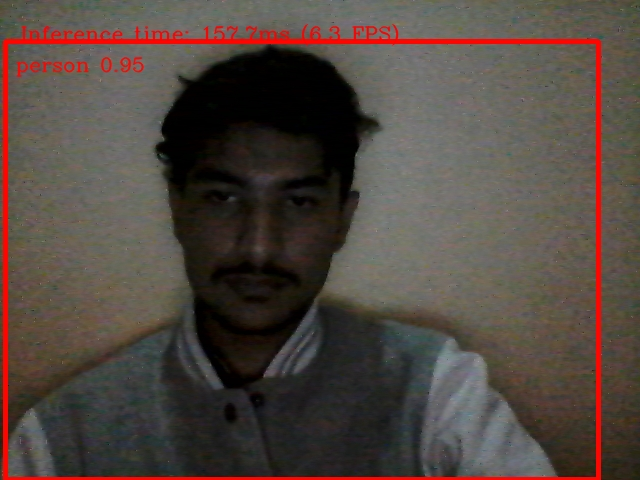

In [ ]:
run_object_detection(source=0, flip=True, use_popup=False)